# Paper Figures Reproduction (v2)

This notebook reproduces the analysis from `paper_figures.ipynb` using the clean `MLflowBenchmarkManager` and `BenchmarkAnalyzer`.
It covers:
1. Qualitative Evaluation (Filter Complete Runs)
2. Performance Analysis (Boxplots)
3. Statistical Analysis (CD Diagrams)
4. Tuning Gain (Pareto Frontier)

In [1]:
import sys
import os
from pathlib import Path
import pandas as pd

# Ensure we can import local modules
current_dir = Path(os.getcwd())
if str(current_dir) not in sys.path:
    sys.path.append(str(current_dir))

from mlflow_manager import MLflowBenchmarkManager
from benchmark_analysis import BenchmarkAnalyzer, plot_heatmap, plot_metric_boxplot, plot_cd_diagram, plot_pareto

# Setup Paths & URI
PROJECT_ROOT = Path("..").resolve()
MLFLOW_DB_PATH = PROJECT_ROOT / "results/mlflow_snapshot_27_01.db"
TRACKING_URI = f"sqlite:///{MLFLOW_DB_PATH}"
CONFIG_PATH = PROJECT_ROOT / "configs/benchmark_config.yaml"

print(f"Tracking URI: {TRACKING_URI}")
print(f"Config Path: {CONFIG_PATH}")

# Initialize Manager with explicit Tracking URI
manager = MLflowBenchmarkManager(CONFIG_PATH, tracking_uri=TRACKING_URI)
analyzer = BenchmarkAnalyzer(manager)

print("Environment Setup Complete.")

Tracking URI: sqlite:////home/fchavell/tsseg-project/tsseg-exp/results/mlflow_snapshot_27_01.db
Config Path: /home/fchavell/tsseg-project/tsseg-exp/configs/benchmark_config.yaml


2026/01/27 16:36:34 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/27 16:36:34 INFO mlflow.store.db.utils: Updating database tables
2026/01/27 16:36:34 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/27 16:36:34 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/27 16:36:34 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/27 16:36:34 INFO alembic.runtime.migration: Will assume non-transactional DDL.


Environment Setup Complete.


## 1. Qualitative Evaluation

Fetch parent runs for Unsupervised and Semi-Supervised modes, validate completeness (check against Expected Series counts), and visualize valid results.

Fetching parent stats (SQL accelerated) for keys: ['unsupervised', 'semi_supervised']...
Valid Parents Found: 1036
Modes found: ['guided' 'default']
mode
guided     561
default    475
Name: count, dtype: int64


,run_id,experiment_id,start_time,status,algorithm,dataset,parent_run_id,total_children,children_finished,children_failed,mode,is_complete
2001,5b6268f3544141f6ad904f53f6a82d7c,22,2026-01-27 03:07:46.496,FINISHED,window,mocap,5b6268f3544141f6ad904f53f6a82d7c,9,9,0,guided,True
2000,55ac47741f9142e99906a6282d1bf11f,22,2026-01-27 03:06:54.123,FINISHED,window,skab,55ac47741f9142e99906a6282d1bf11f,34,34,0,guided,True
1999,808a7ff5697048b28b00ce8f7c747b7f,22,2026-01-27 03:05:52.559,FINISHED,window,actrectut,808a7ff5697048b28b00ce8f7c747b7f,2,2,0,guided,True
1998,64212b09406b41e98fd8cd8ced2a2ae4,22,2026-01-27 03:05:09.922,FINISHED,window,pamap2,64212b09406b41e98fd8cd8ced2a2ae4,9,9,0,guided,True
1997,4c081f84c23f441e99a80b50e160ce82,22,2026-01-27 03:04:14.699,FINISHED,window,usc-had,4c081f84c23f441e99a80b50e160ce82,70,70,0,guided,True



--- Default ---


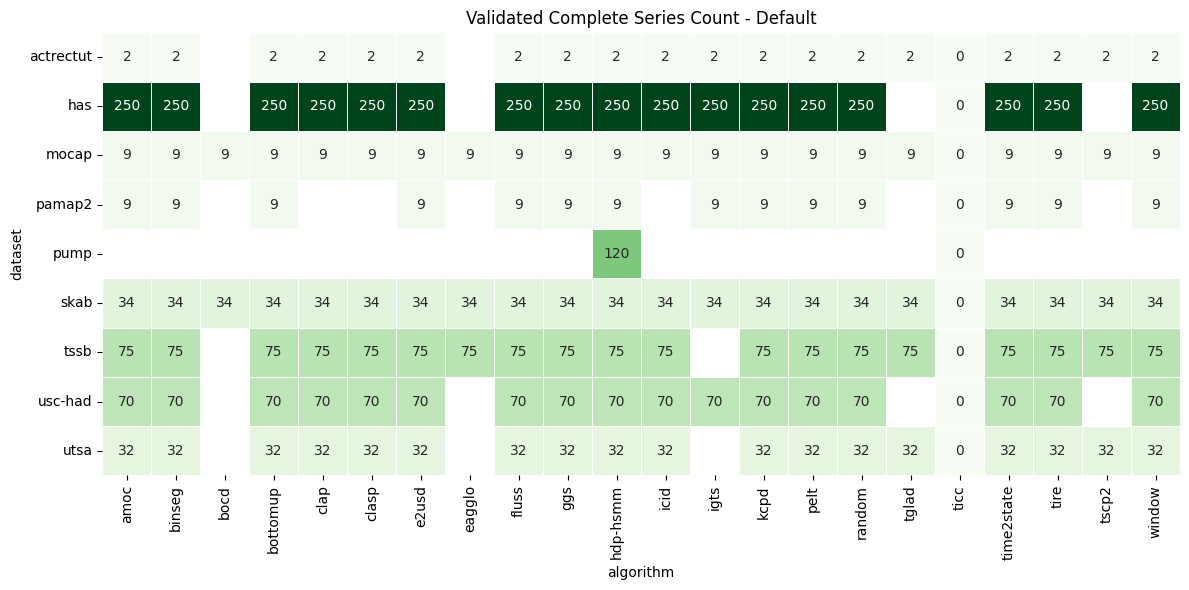


--- Guided ---


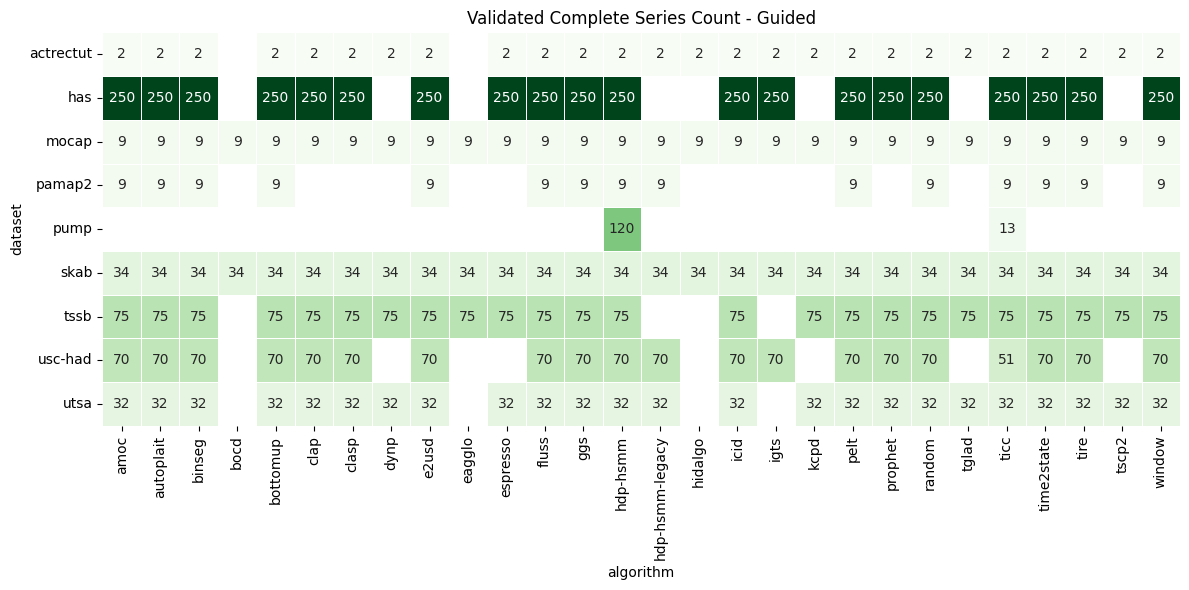

In [2]:
# 1. Fetch Stats (Auto-fetches all groups defined in config if no keys provided)
df_parents = analyzer.fetch_parent_runs_stats(['unsupervised', 'semi_supervised'])

# 2. Validate
valid_parents = analyzer.validate_completeness(df_parents)

print(f"Valid Parents Found: {len(valid_parents)}")
if 'mode' in valid_parents.columns:
    print("Modes found:", valid_parents['mode'].unique())
    print(valid_parents['mode'].value_counts())

display(valid_parents.head())

# 3. Visualize Heatmap
# Use configured groups (Logical Modes: default, guided)
unique_modes = sorted(valid_parents['mode'].unique()) if 'mode' in valid_parents.columns else []

for mode in ['default', 'guided']:
    if mode in unique_modes:
        print(f"\n--- {mode.capitalize()} ---")
        plot_heatmap(valid_parents[valid_parents['mode'] == mode], mode.capitalize())
    else:
        print(f"\n--- {mode.capitalize()} (No Data found) ---")

## 2. Performance Analysis

Fetch child metrics (F1-Score, Covering Score) for the validated parents and visualize distributions.

In [3]:
# Import for widgets and display
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from benchmark_analysis import EXPECTED_SERIES

# === HELPERS ===
def format_label(text, type='text'):
    if not isinstance(text, str): return text
    metric_map = {
        'metrics.adjusted_mutual_info_score': 'AMI',
        'metrics.adjusted_rand_score': 'ARI',
        'metrics.covering_score': 'Covering Score',
        'metrics.f1_score': 'F1-Score',
        'metrics.state_matching_score': 'State Matching Score',
        'duration_s': 'Time (s)',
    }
    # Clean prefix
    clean_text = text.replace('metrics.', '') if text.startswith('metrics.') else text
    
    if text in metric_map: return metric_map[text]
    if clean_text in metric_map: return metric_map[clean_text]
    
    if type == 'algo': return text.upper()
    return clean_text.replace('_', ' ').title()

def save_fig(fig, filename, category):
    base_dir = PROJECT_ROOT / "figures" / category
    os.makedirs(base_dir, exist_ok=True)
    try:
        fig.savefig(base_dir / f"{filename}.pdf", bbox_inches='tight', dpi=300)
    except Exception as e:
        print(f"Error saving figure: {e}")

# 1. Fetch Full Metrics (Merged Strategy)
print("Fetching metrics for ALL candidate parents (Merging Series)...")
# We re-validate with strategy='merge' to include all potential parents (patches/retries)
valid_parents_merged = analyzer.validate_completeness(df_parents, strategy='merge')
# And deduplicate at the series level (keep latest run per series/dataset/algo)
df_metrics = analyzer.fetch_metrics_for_parents(valid_parents_merged, deduplicate_series=True)

if not df_metrics.empty:
    print(f"Fetched {len(df_metrics)} metric records (Active).")
    
    # 2. Fair Comparison Filters
    required_datasets = set(EXPECTED_SERIES.keys()) - {'pamap2'}
    whitelisted_algos = {'hdp-hsmm', 'ticc', 'hdp_hsmm'}
    blacklisted_algos = {'vsax'}
    
    # Calculate Total Expected Series Count for the required datasets
    total_required_series = sum(EXPECTED_SERIES[ds] for ds in required_datasets)
    
    # Determine coverage based on the NOW MERGED metrics
    algo_dataset_pairs = df_metrics[['algorithm', 'dataset']].drop_duplicates()
    algo_coverage = algo_dataset_pairs.groupby('algorithm')['dataset'].agg(set)
    
    kept_algos = []
    dropped_algos = {}
    
    # NEW: Store rates per (algo, mode)
    algo_mode_rates = {} 
    
    unique_algos = sorted(valid_parents['algorithm'].unique())
    available_modes = df_metrics['mode'].unique()
    
    for algo in unique_algos:
        if algo in blacklisted_algos:
            continue
            
        covered = algo_coverage.get(algo, set())
        missing = required_datasets - covered
        
        # Calculate Completion Rate PER MODE
        # (Active Runs in Required Datasets) / Total Expected
        for m in available_modes:
            runs_in_required = len(df_metrics[
                (df_metrics['algorithm'] == algo) & 
                (df_metrics['mode'] == m) &
                (df_metrics['dataset'].isin(required_datasets))
            ])
            algo_mode_rates[(algo, m)] = runs_in_required / total_required_series if total_required_series > 0 else 0
        
        if algo in whitelisted_algos:
            kept_algos.append(algo)
        elif not missing:
            # We keep all fully-present algorithms regardless of completion rate
            # The UI will handle filtering based on rate
            kept_algos.append(algo)
        else:
            reasons = []
            if missing: reasons.append(f"Missing {len(missing)} datasets")
            dropped_algos[algo] = ", ".join(reasons)
            
    print(f"--- Fair Comparison Filter ---")
    print(f"Kept Algorithms ({len(kept_algos)}): {kept_algos}")
    if dropped_algos:
        print(f"Dropped Algorithms (Missing Datasets):")
        for k, v in dropped_algos.items():
            print(f"  - {k}: {v}")
            
    # DEBUG: Print Completion Rates for review
    print("\n--- Completion Rates (Top Failures) ---")
    for (algo, m), rate in sorted(algo_mode_rates.items()):
        if algo in kept_algos and rate < 0.95:
             print(f"  {algo} [{m}]: {rate:.1%}")
    
    # Apply Filter to Metrics
    df_plot = df_metrics[df_metrics['algorithm'].isin(kept_algos)].copy()
    
    # === IMPUTATION Step ===
    print("\n--- Imputation (Worst Case) ---")
    imputed_rows = []
    
    # Identify relevant metric columns globally
    all_metric_cols = [c for c in df_plot.columns if c.startswith('metrics.')]
    
    target_datasets = sorted(list(required_datasets)) 
    all_known_datasets = sorted(EXPECTED_SERIES.keys())
    
    for algo in kept_algos:
        # Determine valid metrics for THIS algo
        algo_mask = df_plot['algorithm'] == algo
        algo_data = df_plot[algo_mask]
        
        # Valid metrics: columns that have at least one non-NaN value
        valid_metrics_for_algo = []
        if not algo_data.empty:
            valid_metrics_for_algo = [m for m in all_metric_cols if algo_data[m].notna().any()]
        else:
            valid_metrics_for_algo = ['metrics.covering_score', 'metrics.f1_score'] # Fallback
        
        for ds in all_known_datasets:
            expected_count = EXPECTED_SERIES[ds]
            
            # Count existing rows
            existing = df_plot[(df_plot['algorithm'] == algo) & (df_plot['dataset'] == ds)]
            count = len(existing)
            
            if count < expected_count:
                missing_count = expected_count - count
                if missing_count > 0:
                    # Create fake rows
                    # Infer Mode
                    mode = 'default' 
                    if not existing.empty:
                        mode = existing.iloc[0]['mode']
                    else:
                        parent_info = valid_parents_merged[(valid_parents_merged['algorithm'] == algo) & (valid_parents_merged['dataset'] == ds)]
                        if not parent_info.empty:
                            mode = parent_info.iloc[0]['mode']
                        else:
                            any_algo_mode = valid_parents_merged[valid_parents_merged['algorithm'] == algo]['mode'].unique()
                            if len(any_algo_mode) > 0:
                                mode = any_algo_mode[0]

                    fake_row = {
                        'algorithm': algo,
                        'dataset': ds,
                        'mode': mode,
                        'is_imputed': True
                    }
                    
                    # Zero-out ONLY valid metrics
                    for m in valid_metrics_for_algo:
                        fake_row[m] = 0.0
                        
                    if 'duration_s' in df_plot.columns:
                        fake_row['duration_s'] = np.nan 

                    for _ in range(missing_count):
                        imputed_rows.append(fake_row)
                        
    if imputed_rows:
        print(f"Imputing {len(imputed_rows)} missing series with 0.0 scores.")
        df_imputed = pd.DataFrame(imputed_rows)
        # Fix types to match df_plot to avoid warnings
        for c in df_plot.columns:
            if c not in df_imputed.columns:
                df_imputed[c] = np.nan
        df_plot = pd.concat([df_plot, df_imputed], ignore_index=True)
    else:
        print("No imputation needed.")

    # Identify Metric Columns
    metric_cols = [c for c in df_plot.columns if c.startswith('metrics.')]
    if 'duration_s' in df_plot.columns: metric_cols.append('duration_s')
    metric_cols = sorted(metric_cols)
    
    all_datasets = sorted(df_plot['dataset'].unique())
    
    # === INTERACTIVE PLOT ===
    
    w_mode = widgets.Dropdown(options=['default', 'guided'], value='default', description='Mode:')
    w_metric = widgets.Dropdown(options=metric_cols, value='metrics.covering_score' if 'metrics.covering_score' in metric_cols else metric_cols[0], description='Metric:')
    w_agg = widgets.Dropdown(options=['Macro (Mean per Dataset)', 'Micro (All Runs)'], value='Macro (Mean per Dataset)', description='Aggregation:')
    w_min_success = widgets.FloatSlider(value=0.75, min=0.0, max=1.0, step=0.05, description='Min Success %')
    w_dots = widgets.Checkbox(value=True, description='Show Dots')
    w_random = widgets.Checkbox(value=True, description='Show Random')
    w_datasets = widgets.SelectMultiple(options=all_datasets, value=tuple(all_datasets), description='Datasets:', rows=8)
    
    out = widgets.Output()
    
    def update_plot(change=None):
        with out:
            clear_output(wait=True)
            mode = w_mode.value
            metric = w_metric.value
            sel_ds = w_datasets.value
            min_rate = w_min_success.value
            
            # Dynamic Filter: Algorithms meeting success rate (IN CURRENT MODE) on SELECTED DATASETS
            active_algos = []
            total_expected_in_selection = sum(EXPECTED_SERIES.get(d, 0) for d in sel_ds)
            
            # Pre-filter metrics for rate calc (optim)
            df_metrics_mode = df_metrics[df_metrics['mode'] == mode]
            
            for a in kept_algos:
                if a in whitelisted_algos:
                    active_algos.append(a)
                    continue
                
                # Dynamic Rate Calculation on Selected Datasets
                if total_expected_in_selection == 0:
                    rate = 0.0
                else:
                    # Count valid runs in df_metrics (raw, unimputed) for this algo/dataset(s)
                    valid_count = len(df_metrics_mode[
                        (df_metrics_mode['algorithm'] == a) & 
                        (df_metrics_mode['dataset'].isin(sel_ds))
                    ])
                    rate = valid_count / total_expected_in_selection

                if rate >= min_rate:
                    active_algos.append(a)

            # Filter Data
            mask = (df_plot['mode'] == mode) & \
                   (df_plot['dataset'].isin(sel_ds)) & \
                   (df_plot['algorithm'].isin(active_algos))
            data = df_plot[mask].copy()
            
            if not w_random.value:
                data = data[data['algorithm'].str.lower() != 'random']
                
            if data.empty:
                print(f"No data for Mode='{mode}' (Min Rate={min_rate}). Active Algos: {len(active_algos)}")
                return
                
            # Aggregation
            if w_agg.value.startswith('Macro'):
                if metric not in data.columns: return
                plot_data = data.groupby(['algorithm', 'dataset'])[metric].mean().reset_index()
            else:
                plot_data = data.copy()
                
            if metric not in plot_data.columns: return
            plot_data = plot_data.dropna(subset=[metric])
            
            if plot_data.empty: print("No valid value points."); return
            
            # Formatting
            plot_data.loc[:, 'algo_label'] = plot_data['algorithm'].apply(lambda x: format_label(x, 'algo'))
            
            order = plot_data.groupby('algo_label')[metric].median().sort_values(ascending=False).index
            w_item = 0.4
            width = max(5, len(order) * w_item + 1)
            
            fig, ax = plt.subplots(figsize=(width, 6))
            sns.boxplot(data=plot_data, x='algo_label', y=metric, order=order, palette='viridis', ax=ax, hue='algo_label', legend=False)
            
            if w_dots.value:
                sns.stripplot(data=plot_data, x='algo_label', y=metric, order=order, color='black', alpha=0.3, jitter=True, ax=ax)
                
            ax.set_title(f"{format_label(metric)} - {mode.capitalize()}")
            ax.set_ylabel(format_label(metric))
            ax.set_xlabel("")
            plt.xticks(rotation=45, ha='right')
            plt.grid(axis='y', alpha=0.3)
            
            if 'duration' in metric or 'time' in metric:
                plt.yscale('log')
            elif plot_data[metric].max() <= 1.0 and plot_data[metric].min() >= -0.1:
                plt.ylim(-0.05, 1.05)
                
            plt.tight_layout()
            plt.show()
            
            filename = f"boxplot_{mode}_{metric.replace('metrics.', '')}"
            save_fig(fig, filename, "performance")
            
    # Observers
    w_mode.observe(update_plot, names='value')
    w_metric.observe(update_plot, names='value')
    w_agg.observe(update_plot, names='value')
    w_min_success.observe(update_plot, names='value')
    w_dots.observe(update_plot, names='value')
    w_random.observe(update_plot, names='value')
    w_datasets.observe(update_plot, names='value')
    
    ui = widgets.VBox([
        widgets.HBox([w_mode, w_metric, w_agg]),
        widgets.HBox([w_min_success, w_dots, w_random]),
        widgets.Label("Datasets:"), w_datasets,
        out
    ])
    
    display(ui)
    update_plot()
    
else:
    print("No metrics found.")

Fetching metrics for ALL candidate parents (Merging Series)...
Fetching metrics for children of 1952 parents...
 pivoting 902107 metric records...
 Deduplicating series (latest run) on subset: ['mode', 'algorithm', 'dataset', 'trial_index']...
  Deduplication: Reduced valid runs from 66469 to 23913.
Fetched 23913 metric records (Active).
--- Fair Comparison Filter ---
Kept Algorithms (24): ['amoc', 'autoplait', 'binseg', 'bottomup', 'clap', 'clasp', 'dynp', 'e2usd', 'espresso', 'fluss', 'ggs', 'hdp-hsmm', 'hdp-hsmm-legacy', 'icid', 'kcpd', 'pelt', 'prophet', 'random', 'tglad', 'ticc', 'time2state', 'tire', 'tscp2', 'window']
Dropped Algorithms (Missing Datasets):
  - bocd: Missing 2 datasets
  - eagglo: Missing 2 datasets
  - hidalgo: Missing 2 datasets
  - igts: Missing 2 datasets

--- Completion Rates (Top Failures) ---
  autoplait [default]: 0.0%
  dynp [default]: 0.0%
  dynp [guided]: 54.9%
  espresso [default]: 0.0%
  espresso [guided]: 89.8%
  hdp-hsmm-legacy [default]: 0.0%
  hd

In [4]:
# --- Inspection Cell ---
# Filter runs used in the plot for Default / Clasp / TSSB
target_mode = 'default'
target_algo = 'fluss'
target_dataset = 'tssb'

print(f"--- Inspection: Mode={target_mode}, Algo={target_algo}, Dataset={target_dataset} ---")

if 'df_plot' in locals():
    # Filter df_plot
    inspection_mask = (
        (df_plot['mode'] == target_mode) & 
        (df_plot['algorithm'] == target_algo) & 
        (df_plot['dataset'] == target_dataset)
    )
    
    inspected_runs = df_plot[inspection_mask].copy()
    
    if not inspected_runs.empty:
        print(f"Found {len(inspected_runs)} records.")
        
        # Display explicit full dataframe content (with limited columns for readability but all rows)
        pd.set_option('display.max_rows', None)  # Ensure all rows are shown
        
        cols_to_show = ['run_id', 'algorithm', 'dataset', 'metrics.covering_score']
        if 'is_imputed' in inspected_runs.columns:
            cols_to_show.append('is_imputed')
        if 'trial_index' in inspected_runs.columns:
            cols_to_show.append('trial_index')
            
        cols_to_show = [c for c in cols_to_show if c in inspected_runs.columns]
        
        print("\n--- Full Inspected DataFrame ---")
        display(inspected_runs[cols_to_show])
        pd.reset_option('display.max_rows') # Reset option after display
        
        # Display Average Score
        if 'metrics.covering_score' in inspected_runs.columns:
            avg_score = inspected_runs['metrics.covering_score'].mean()
            print(f"\nAverage Covering Score: {avg_score:.4f}")
    else:
        print("No records found in df_plot for this combination.")
else:
    print("df_plot is not defined. Run the cell above first.")

--- Inspection: Mode=default, Algo=fluss, Dataset=tssb ---
Found 75 records.

--- Full Inspected DataFrame ---


,run_id,algorithm,dataset,metrics.covering_score,is_imputed,trial_index
5187,05737ad0139d4a388f87fdaded8c6624,fluss,tssb,0.947842,NaN,1
5207,a01accf662ab432fa752187906d686fb,fluss,tssb,0.875830,NaN,2
5223,6b5bda24b0964228961ed23e15d87e8c,fluss,tssb,0.880142,NaN,3
5232,b015beee1cb248838ee580f08a25a3a2,fluss,tssb,0.939453,NaN,4
5245,2b3f7465b3b84b30948b33af6baac700,fluss,tssb,0.460382,NaN,5
5258,04df485c614342cf92e988518ecb2e3e,fluss,tssb,0.738447,NaN,6
5275,3054352841c647f69a48b19dd2eddb80,fluss,tssb,0.856350,NaN,7
5293,3b2e95ab333c4e2185d761f459c17141,fluss,tssb,0.375000,NaN,8
5303,3b7ce1caf0f243b2b76d88d0d6c30120,fluss,tssb,0.950263,NaN,9
5326,9d44ff1b453048f6bb02f526b0c499dd,fluss,tssb,0.956177,NaN,10



Average Covering Score: 0.6505


In [5]:
# --- Inspection Cell ---
# Filter runs used in the plot for Default / Clasp / TSSB
target_mode = 'default'
target_algo = 'clasp'
target_dataset = 'tssb'

print(f"--- Inspection: Mode={target_mode}, Algo={target_algo}, Dataset={target_dataset} ---")

if 'df_plot' in locals():
    # Filter df_plot
    inspection_mask = (
        (df_plot['mode'] == target_mode) & 
        (df_plot['algorithm'] == target_algo) & 
        (df_plot['dataset'] == target_dataset)
    )
    
    inspected_runs = df_plot[inspection_mask].copy()
    
    if not inspected_runs.empty:
        print(f"Found {len(inspected_runs)} records.")
        # Select relevant columns for display
        cols_to_show = ['run_id', 'algorithm', 'dataset', 'metrics.covering_score']
        if 'is_imputed' in inspected_runs.columns:
            cols_to_show.append('is_imputed')
        if 'trial_index' in inspected_runs.columns:
            cols_to_show.append('trial_index')
            
        # Handle missing columns safely
        cols_to_show = [c for c in cols_to_show if c in inspected_runs.columns]
        
        display(inspected_runs[cols_to_show])
    else:
        print("No records found in df_plot for this combination.")
else:
    print("df_plot is not defined. Run the cell above first.")

--- Inspection: Mode=default, Algo=clasp, Dataset=tssb ---
Found 75 records.


,run_id,algorithm,dataset,metrics.covering_score,is_imputed,trial_index
5185,c703b7ef8084474f897ccd18bb5c959b,clasp,tssb,0.807435,NaN,1
5211,0e342516161147c3b42b04a9d5303f77,clasp,tssb,0.985497,NaN,2
5216,45954c0022424e57a96ce62eb9b48dee,clasp,tssb,0.973403,NaN,3
5229,3821bb91d1ba4884ba8c2711a2691d56,clasp,tssb,0.975305,NaN,4
5240,57e84b4b824e4ad4b77df48bd09073a0,clasp,tssb,0.993769,NaN,5
...,...,...,...,...,...,...
5803,ed7f2b22a6dd4f2a9b284adc0bd860f0,clasp,tssb,0.986634,NaN,71
5808,d07b0381431d40ae92808ecf94ebb5ab,clasp,tssb,0.962815,NaN,72
5811,03ed9fd74d6943cab75dfd9116959f41,clasp,tssb,0.810477,NaN,73
5814,9be2f67d00bd45e0a5a0600277ea24fc,clasp,tssb,0.726924,NaN,74


## 3. Statistical Analysis

Critical Difference (CD) Diagrams to compare algorithm rankings.

In [6]:
# Use Imputed Data from previous step for fair comparison (penalize failures)
# If not available (cell not run), fallback to raw metrics (biased)
if 'df_plot' in locals():
    df_cd_source = df_plot.copy()
elif not df_metrics.empty:
    print("Warning: Using raw metrics (unimputed). Run previous cell for fair comparison.")
    df_cd_source = df_metrics.copy()
else:
    df_cd_source = pd.DataFrame()

if not df_cd_source.empty:
    import ipywidgets as widgets
    from IPython.display import display, clear_output

    # Identify Features
    metric_cols = sorted([c for c in df_cd_source.columns if c.startswith('metrics.')])
    modes = sorted(df_cd_source['mode'].unique()) if 'mode' in df_cd_source.columns else ['default']
    all_datasets = sorted(df_cd_source['dataset'].unique())
    
    # UI Components
    w_mode_cd = widgets.Dropdown(options=modes, value=modes[0] if modes else None, description='Mode:')
    
    default_metric = 'metrics.covering_score' if 'metrics.covering_score' in metric_cols else (metric_cols[0] if metric_cols else None)
    w_metric_cd = widgets.Dropdown(options=metric_cols, value=default_metric, description='Metric:')
    
    w_min_success_cd = widgets.FloatSlider(value=0.75, min=0.0, max=1.0, step=0.05, description='Min Success %')
    
    w_datasets_cd = widgets.SelectMultiple(options=all_datasets, value=tuple(all_datasets), description='Datasets:', rows=8)
    
    out_cd = widgets.Output()

    def update_cd(change=None):
        with out_cd:
            clear_output(wait=True)
            mode = w_mode_cd.value
            metric = w_metric_cd.value
            min_rate = w_min_success_cd.value
            sel_ds = w_datasets_cd.value
            
            if not mode or not metric:
                print("Missing mode or metric selection.")
                return

            if not sel_ds:
                print("Please select at least one dataset.")
                return

            # Filter Active Algos based on Success Rate (using dynamic selection)
            active_algos = []
            candidates = df_cd_source['algorithm'].unique()
            
            whitelist = whitelisted_algos if 'whitelisted_algos' in locals() else set()
            
            # Calculate total expected series for the selection
            vals_in_selection = [EXPECTED_SERIES.get(d, 0) for d in sel_ds]
            total_expected_in_selection = sum(vals_in_selection)
            
            # Use raw metrics for counting real success (unimputed) to calculate rate
            df_raw_mode = df_metrics[df_metrics['mode'] == mode]

            for a in candidates:
                if a in whitelist:
                    active_algos.append(a)
                    continue
                
                # Dynamic Rate Calc
                if total_expected_in_selection == 0:
                    rate = 0.0
                else:
                    valid_count = len(df_raw_mode[
                        (df_raw_mode['algorithm'] == a) & 
                        (df_raw_mode['dataset'].isin(sel_ds))
                    ])
                    rate = valid_count / total_expected_in_selection
                
                if rate >= min_rate:
                    active_algos.append(a)
                    
            # Filter Data
            mask = (df_cd_source['mode'] == mode) & \
                   (df_cd_source['dataset'].isin(sel_ds)) & \
                   (df_cd_source['algorithm'].isin(active_algos))
            
            # Ideally remove Random for CD diagrams if not desired
            # mask &= (df_cd_source['algorithm'].str.lower() != 'random')
            
            data_filtered = df_cd_source[mask].copy()
            
            unique_algos_count = len(data_filtered['algorithm'].unique())
            if unique_algos_count < 2:
                print(f"Need at least 2 algorithms to compare. Found {unique_algos_count} (Filter: Min Rate {min_rate}).")
                if unique_algos_count > 0:
                    print(f"Algorithms: {data_filtered['algorithm'].unique()}")
                return

            print(f"Generating Critical Difference Diagram...")
            print(f"Mode: {mode.capitalize()} | Metric: {format_label(metric)} | Min Success: {min_rate:.0%} | Algos: {unique_algos_count}")
            print(f"Datasets: {len(sel_ds)} selected")
            
            try:
                import warnings
                # plot_cd_diagram handles formatting internally usually, but we pass raw DF
                # It requires Orange3.
                with warnings.catch_warnings():
                    # Suppress aeon warning about identical estimators
                    warnings.filterwarnings("ignore", message=".*same performanceon.*")
                    plot_cd_diagram(data_filtered, metric, f"CD Diagram - {mode.capitalize()}")
                
                # Check for Figure saving? plot_cd_diagram normally creates a plot.
                # If we want to save:
                # fig = plt.gcf()
                # save_fig(fig, f"cd_diagram_{mode}_{metric.replace('metrics.', '')}", "statistical")
                
            except Exception as e:
                print(f"Error: {e}")
                print("Ensure 'Orange3' is installed and data has overlapping datasets.")

    # Observers
    w_mode_cd.observe(update_cd, names='value')
    w_metric_cd.observe(update_cd, names='value')
    w_min_success_cd.observe(update_cd, names='value')
    w_datasets_cd.observe(update_cd, names='value')
    
    ui_cd = widgets.VBox([
        widgets.HBox([w_mode_cd, w_metric_cd]),
        w_min_success_cd,
        widgets.Label("Datasets:"), w_datasets_cd,
        out_cd
    ])
    
    display(ui_cd)
    update_cd()
else:
    print("No data available for Statistical Analysis.")

## 4. Pareto Frontier (Tuning Gain)

Fetch Grid Search results, identify the best configuration per Algorithm/Dataset, and compare against standard results on a Quality vs Time log-scale plot.

In [7]:
# 1. Fetch Grid Data
print("Fetching Grid Search data...")
df_grid_parents = analyzer.fetch_parent_runs_stats(['grid_unsupervised', 'grid_supervised'])

if not df_grid_parents.empty and 'df_metrics' in locals() and not df_metrics.empty:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    import seaborn as sns
    import matplotlib.pyplot as plt

    # === DATA PREPARATION ===
    
    # 1. Validate & Fetch Grid Metrics
    valid_grid = analyzer.validate_completeness(df_grid_parents, strategy='merge')
    df_grid_metrics = analyzer.fetch_metrics_for_parents(valid_grid, deduplicate_series=True)
    
    # Normalize Grid Modes
    if not df_grid_metrics.empty and 'mode' in df_grid_metrics.columns:
        print(f"Grid Modes (Raw): {df_grid_metrics['mode'].unique()}")
        mode_map = {
            'unsupervised': 'default', 
            'semi-supervised': 'guided',
            'grid_unsupervised': 'default', 
            'grid_supervised': 'guided',
            'grid_default': 'default',
            'grid_guided': 'guided'
        }
        df_grid_metrics['mode'] = df_grid_metrics['mode'].replace(mode_map)
        print(f"Grid Modes (Norm): {df_grid_metrics['mode'].unique()}")

    # Standardize Time Columns
    if not df_grid_metrics.empty:
        if 'duration_s' not in df_grid_metrics.columns and 'metrics.execution_time_seconds' in df_grid_metrics.columns:
            df_grid_metrics = df_grid_metrics.rename(columns={'metrics.execution_time_seconds': 'duration_s'})

    df_standard = df_metrics.copy()
    if 'duration_s' not in df_standard.columns and 'metrics.execution_time_seconds' in df_standard.columns:
        df_standard = df_standard.rename(columns={'metrics.execution_time_seconds': 'duration_s'})

    time_key = 'duration_s'

    # Identify Common Metrics
    grid_cols = [c for c in df_grid_metrics.columns if c.startswith('metrics.')]
    std_cols = [c for c in df_standard.columns if c.startswith('metrics.')]
    common_metrics = sorted(list(set(grid_cols) & set(std_cols)))
    if not common_metrics: common_metrics = ['metrics.covering_score']
    
    if not df_grid_metrics.empty and not df_standard.empty:
            
        # UI Setup
        available_modes = df_standard['mode'].unique()
        modes = sorted([m for m in available_modes if m in ['default', 'guided']])
        if not modes: modes = sorted(available_modes)

        w_mode_par = widgets.Dropdown(options=modes, value='default' if 'default' in modes else modes[0], description='Mode:')
        pref = 'metrics.covering_score'
        w_metric_par = widgets.Dropdown(options=common_metrics, value=pref if pref in common_metrics else common_metrics[0], description='Metric:')
        out_par = widgets.Output()
        
        def get_best_run_data(df, group_cols, run_id_col, metric):
            """
            Selects the BEST Run (Parent or Trial) for each group.
            Strategy: Maximize Average Metric over the Run.
            """
            # Calculate Mean Metric per Run
            run_scores = df.groupby(group_cols + [run_id_col])[metric].mean().reset_index()
            
            # Find Best Run ID for each Group
            best_run_idx = run_scores.groupby(group_cols)[metric].idxmax()
            best_runs = run_scores.loc[best_run_idx]
            
            # Keep only data belonging to these Best Runs
            best_run_ids = best_runs[run_id_col].unique()
            return df[df[run_id_col].isin(best_run_ids)].copy()

        def update_pareto(change=None):
            with out_par:
                clear_output(wait=True)
                mode = w_mode_par.value
                metric = w_metric_par.value
                
                # 1. Filter & Clean
                grid_subset = df_grid_metrics[df_grid_metrics['mode'] == mode].dropna(subset=[metric])
                std_subset = df_standard[df_standard['mode'] == mode].dropna(subset=[metric])
                
                if grid_subset.empty:
                    print(f"No valid grid data for {mode} / {metric}")
                    return

                # 2. Select BEST Grid Config (Trial) per (Algo, Dataset)
                # Assuming 'run_id' identifies a Trial (Hyperparam Config)
                # If 'run_id' is missing (index?), reset index
                if 'run_id' not in grid_subset.columns:
                    grid_subset = grid_subset.reset_index() # Ensure run_id is available if it was index
                    if 'run_id' not in grid_subset.columns:
                         # Fallback to parent_run_id if child run id not found (unlikely)
                         grid_subset['run_id'] = grid_subset['parent_run_id']

                df_grid_best = get_best_run_data(
                    grid_subset, 
                    ['algorithm', 'dataset'], 
                    'run_id', 
                    metric
                )
                df_grid_best['Type'] = 'Grid'
                
                # 3. Select BEST Standard Run (Parent) per (Algo, Dataset)
                # This explicitly satisfies "Duplicate -> Keep Best"
                if 'parent_run_id' not in std_subset.columns:
                     std_subset['run_id'] = std_subset.index # Fallback
                else:
                     std_subset['run_id'] = std_subset['parent_run_id']
                     
                df_std_best = get_best_run_data(
                    std_subset,
                    ['algorithm', 'dataset'],
                    'run_id',
                    metric
                )
                df_std_best['Type'] = 'Standard'
                
                # 4. Strict Intersection (Compare apples to apples)
                common_keys = ['algorithm', 'dataset']
                common_pairs = pd.merge(
                    df_grid_best[common_keys].drop_duplicates(),
                    df_std_best[common_keys].drop_duplicates(),
                    on=common_keys
                )
                
                if common_pairs.empty:
                    print(f"No intersection found for {mode}.")
                    return
                
                # Filter to intersection
                df_grid_ready = pd.merge(df_grid_best, common_pairs, on=common_keys)
                df_std_ready = pd.merge(df_std_best, common_pairs, on=common_keys)
                
                print(f"Plotting {len(common_pairs)} common (Algo, Dataset) pairs.")

                # 5. Combine & Aggregate
                keep_cols = ['algorithm', 'dataset', 'Type', time_key, metric]
                df_viz = pd.concat([df_std_ready[keep_cols], df_grid_ready[keep_cols]], ignore_index=True)
                
                # Mean over datasets
                agg = df_viz.groupby(['algorithm', 'Type'])[[metric, time_key]].mean().reset_index()

                # 6. Plot
                plt.figure(figsize=(10, 7))
                markers = {"Standard": "o", "Grid": "X"}
                
                sns.scatterplot(
                    data=agg, x=time_key, y=metric, 
                    hue='algorithm', style='Type', 
                    markers=markers, s=150, alpha=0.9, palette='viridis'
                )
                
                # Connectors
                for algo in agg['algorithm'].unique():
                    pair = agg[agg['algorithm'] == algo]
                    if len(pair) == 2:
                        row_std = pair[pair['Type'] == 'Standard'].iloc[0]
                        row_grid = pair[pair['Type'] == 'Grid'].iloc[0]
                        plt.plot(
                            [row_std[time_key], row_grid[time_key]],
                            [row_std[metric], row_grid[metric]],
                            color='gray', alpha=0.3, linestyle='-', zorder=1
                        )
                
                # Labels
                for i, row in agg.iterrows():
                    txt = format_label(row['algorithm'], type='algo') if 'format_label' in globals() else row['algorithm']
                    plt.text(row[time_key], row[metric], f"  {txt}", fontsize=9, ha='left', va='center', fontweight='light')

                plt.xscale('log')
                if not agg[time_key].empty:
                    plt.xlim(agg[time_key].min() * 0.5, agg[time_key].max() * 3.0)
                
                plt.grid(True, which='major', linestyle='-', alpha=0.3)
                plt.grid(True, which='minor', linestyle=':', alpha=0.15)
                
                m_name = format_label(metric) if 'format_label' in globals() else metric
                plt.xlabel("Time (s) [Log Scale]")
                plt.ylabel(m_name)
                plt.title(f"Pareto Frontier ({mode.capitalize()})\nOptimized for {m_name}")
                plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
                plt.tight_layout()
                plt.show()

        w_mode_par.observe(update_pareto, names='value')
        w_metric_par.observe(update_pareto, names='value')
        display(widgets.VBox([widgets.HBox([w_mode_par, w_metric_par]), out_par]))
        update_pareto()
            
    else:
        print(f"Missing Data.")

else:
    print("Dependencies missing.")

Fetching Grid Search data...
Fetching parent stats (SQL accelerated) for keys: ['grid_unsupervised', 'grid_supervised']...
Fetching metrics for children of 5920 parents...
 pivoting 2737832 metric records...
 Deduplicating series (latest run) on subset: ['mode', 'algorithm', 'dataset', 'trial_index']...
  Deduplication: Reduced valid runs from 203186 to 17845.
Grid Modes (Raw): ['grid_guided' 'grid_default']
Grid Modes (Norm): ['guided' 'default']


## 5. Scatterplot Exploration (State Detection)

Interactive scatterplot to explore the trade-offs between two metrics, specifically for algorithms that handle state detection (clustering/segmentation).

In [8]:
# List of known State Detection algorithms (Manually curated or dynamic)
STATE_DETECTION_ALGOS = {
    'vsax', 'time2state', 'e2usd', 'ticc', 'vqtss', 'clap', 'hmm', 
    'autoplait', 'random', 'hidalgo', 'hdp-hsmm', 'hdp_hsmm', 'patss'
}

# Use Imputed Data if available to be consistent with Boxplots
source_df = df_plot if 'df_plot' in locals() else (df_metrics if 'df_metrics' in locals() else pd.DataFrame())

if not source_df.empty:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    import matplotlib.pyplot as plt
    import seaborn as sns

    # --- SETUP ---
    # 1. Attributes
    all_metrics = sorted([c for c in source_df.columns if c.startswith('metrics.') or c in ['duration_s']])
    available_modes = sorted(source_df['mode'].unique()) if 'mode' in source_df.columns else ['default']
    all_ds = sorted(source_df['dataset'].unique())

    # 2. Filter Algorithms (Intersection of Present & State Detection)
    present_algos = set(source_df['algorithm'].unique())
    # Allow loose matching (e.g. case insensitive)
    valid_algos = []
    for a in present_algos:
        if a.lower() in STATE_DETECTION_ALGOS or a in STATE_DETECTION_ALGOS:
            valid_algos.append(a)
            
    valid_algos = sorted(valid_algos)

    if not valid_algos:
        print("No State Detection algorithms found in the current data.")
    else:
        # --- UI COMPONENTS ---
        w_mode_sc = widgets.Dropdown(options=available_modes, value=available_modes[0], description='Mode:')
        
        # Default X and Y
        def_x = 'metrics.covering_score' if 'metrics.covering_score' in all_metrics else all_metrics[0]
        def_y = 'metrics.f1_score' if 'metrics.f1_score' in all_metrics else (all_metrics[1] if len(all_metrics)>1 else all_metrics[0])
        
        w_x = widgets.Dropdown(options=all_metrics, value=def_x, description='X Axis:')
        w_y = widgets.Dropdown(options=all_metrics, value=def_y, description='Y Axis:')
        
        w_algos_sc = widgets.SelectMultiple(options=valid_algos, value=tuple(valid_algos), description='Algos:', rows=len(valid_algos))
        w_ds_sc = widgets.SelectMultiple(options=all_ds, value=tuple(all_ds), description='Datasets:', rows=6)
        
        w_agg_sc = widgets.Checkbox(value=True, description='Aggregate by Algo (Mean)')
        
        out_sc = widgets.Output()

        def update_scatter(change=None):
            with out_sc:
                clear_output(wait=True)
                mode = w_mode_sc.value
                x_metric = w_x.value
                y_metric = w_y.value
                sel_algos = w_algos_sc.value
                sel_ds = w_ds_sc.value
                do_agg = w_agg_sc.value
                
                if not sel_algos or not sel_ds:
                    print("Select at least one algorithm and dataset.")
                    return
                
                # Filter
                mask = (source_df['mode'] == mode) & \
                       (source_df['algorithm'].isin(sel_algos)) & \
                       (source_df['dataset'].isin(sel_ds))
                
                data = source_df[mask].copy()
                
                if data.empty:
                    print("No data for current selection.")
                    return
                
                # Check for NaNs in chosen metrics
                data = data.dropna(subset=[x_metric, y_metric])
                
                if data.empty:
                    print(f"No valid data after NaN drop for {x_metric} and {y_metric}.")
                    return

                # Aggregation
                if do_agg:
                    # Mean over all selected datasets per algorithm
                    plot_data = data.groupby('algorithm')[[x_metric, y_metric]].mean().reset_index()
                else:
                    plot_data = data
                
                # Plot
                plt.figure(figsize=(10, 7))
                
                sns.scatterplot(
                    data=plot_data, x=x_metric, y=y_metric, 
                    hue='algorithm', style='algorithm' if len(sel_algos) < 10 else None,
                    s=150 if do_agg else 60, alpha=0.9 if do_agg else 0.6,
                    palette='viridis'
                )
                
                # Labels (only if aggregated or few points)
                if do_agg or len(plot_data) < 30:
                    for i, row in plot_data.iterrows():
                        label = format_label(row['algorithm'], 'algo') if 'format_label' in globals() else row['algorithm']
                        plt.text(
                            row[x_metric], row[y_metric], 
                            f"  {label}", 
                            fontsize=9, ha='left', va='center', fontweight='light'
                        )
                
                # Scaling logic
                # Log scale for time/duration
                if 'time' in x_metric or 'duration' in x_metric: plt.xscale('log')
                if 'time' in y_metric or 'duration' in y_metric: plt.yscale('log')
                
                # Axis Labels
                xl = format_label(x_metric) if 'format_label' in globals() else x_metric
                yl = format_label(y_metric) if 'format_label' in globals() else y_metric
                
                plt.xlabel(xl)
                plt.ylabel(yl)
                plt.title(f"{xl} vs {yl} ({mode}) - {'Aggregated' if do_agg else 'All Runs'}")
                plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
                plt.grid(True, linestyle='--', alpha=0.5)
                
                plt.tight_layout()
                plt.show()

        # Observers
        w_mode_sc.observe(update_scatter, names='value')
        w_x.observe(update_scatter, names='value')
        w_y.observe(update_scatter, names='value')
        w_algos_sc.observe(update_scatter, names='value')
        w_ds_sc.observe(update_scatter, names='value')
        w_agg_sc.observe(update_scatter, names='value')

        ui_sc = widgets.VBox([
            widgets.HBox([w_mode_sc, w_agg_sc]),
            widgets.HBox([w_x, w_y]),
            widgets.HBox([
                widgets.VBox([widgets.Label("Algos:"), w_algos_sc]),
                widgets.VBox([widgets.Label("Datasets:"), w_ds_sc])
            ]),
            out_sc
        ])

        display(ui_sc)
        update_scatter()

else:
    print("Data source (df_plot or df_metrics) is missing.")

## 6. Regression Analysis & Correlation

Interactive tool to analyze correlation between two metrics, visualize regression lines, and quantify dispersion around the diagonal.

In [ ]:
# Regression Analysis & Correlation
source_df_reg = df_plot if 'df_plot' in locals() else (df_metrics if 'df_metrics' in locals() else pd.DataFrame())

if not source_df_reg.empty:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy import stats
    import numpy as np
    import re
    import os

    # --- SETUP ---
    all_metrics = sorted([c for c in source_df_reg.columns if c.startswith('metrics.') or c in ['duration_s']])
    available_modes = sorted(source_df_reg['mode'].unique()) if 'mode' in source_df_reg.columns else ['default']
    
    # Add 'All' option
    dropdown_modes = ['All'] + available_modes

    all_ds = sorted(source_df_reg['dataset'].unique())
    
    # Filter for State Detection Algos only
    all_algos = sorted(source_df_reg['algorithm'].unique())
    state_algos = all_algos
    if 'STATE_DETECTION_ALGOS' in globals():
        # Filter intersection
        state_algos = [a for a in all_algos if a in STATE_DETECTION_ALGOS or a.lower() in STATE_DETECTION_ALGOS]
        if not state_algos:
            print("Warning: No State Detection algorithms found in data. Using all.")
            state_algos = all_algos
    
    # --- UI COMPONENTS ---
    # Default to 'default' if present, else first available
    def_mode = 'default' if 'default' in available_modes else (available_modes[0] if available_modes else 'All')
    
    w_mode_reg = widgets.Dropdown(options=dropdown_modes, value=def_mode, description='Mode:')
    
    # Default selection
    def_x = 'metrics.covering_score' if 'metrics.covering_score' in all_metrics else all_metrics[0]
    def_y = 'metrics.f1_score' if 'metrics.f1_score' in all_metrics else (all_metrics[1] if len(all_metrics)>1 else all_metrics[0])
    
    w_x_reg = widgets.Dropdown(options=all_metrics, value=def_x, description='X Axis:')
    w_y_reg = widgets.Dropdown(options=all_metrics, value=def_y, description='Y Axis:')
    
    w_algos_reg = widgets.SelectMultiple(options=state_algos, value=tuple(state_algos), description='Algos:', rows=8)
    w_ds_reg = widgets.SelectMultiple(options=all_ds, value=tuple(all_ds), description='Datasets:', rows=6)
    
    w_agg_reg = widgets.Checkbox(value=False, description='Aggregate (Mean per Algo)')
    w_show_reg = widgets.Checkbox(value=True, description='Show Regression Line')
    w_show_diag = widgets.Checkbox(value=True, description='Show Diagonal (y=x)')
    w_show_stats = widgets.Checkbox(value=True, description='Show Stats')
    w_show_ci = widgets.Checkbox(value=True, description='Show Prediction Interval (95%)')
    w_monochrome = widgets.Checkbox(value=False, description='Blue Monochrome Theme')
    w_show_barplots = widgets.Checkbox(value=True, description='Show Barplots (Inserts)')
    
    # Saving controls
    w_save_name = widgets.Text(value='regression_analysis', placeholder='Filename', description='Save Name:')
    btn_png = widgets.Button(description='Save PNG', icon='save')
    btn_pdf = widgets.Button(description='Save PDF', icon='file-pdf-o')
    btn_svg = widgets.Button(description='Save SVG', icon='image')
    
    out_reg = widgets.Output()
    
    # State container for the figure
    plot_state = {'fig': None}

    def clean_label_text(text):
        if not isinstance(text, str): return str(text)
        # Remove duplicated "score" (e.g. "Score Score" -> "Score"), case insensitive, preserving first case
        return re.sub(r'(?i)(score)(\s+score)+', r'\1', text)

    def update_regression(change=None):
        with out_reg:
            clear_output(wait=True)
            mode = w_mode_reg.value
            x_metric = w_x_reg.value
            y_metric = w_y_reg.value
            sel_algos = w_algos_reg.value
            sel_ds = w_ds_reg.value
            do_agg = w_agg_reg.value
            is_monochrome = w_monochrome.value
            show_barplots = w_show_barplots.value
            
            if not sel_algos or not sel_ds:
                print("Select at least one algorithm and dataset.")
                return
            
            # Filter
            mask = (source_df_reg['algorithm'].isin(sel_algos)) & \
                   (source_df_reg['dataset'].isin(sel_ds))
            
            if mode != 'All':
                mask &= (source_df_reg['mode'] == mode)
            
            data = source_df_reg[mask].copy()
            data = data.dropna(subset=[x_metric, y_metric])
            
            if data.empty:
                print("No data for current selection.")
                return

            # Aggregation
            if do_agg:
                # Group by [algorithm] or [algorithm, mode] if 'All' selected
                grp = ['algorithm']
                if mode == 'All':
                    grp.append('mode')
                
                plot_data = data.groupby(grp)[[x_metric, y_metric]].mean().reset_index()
                hue_col = 'algorithm'
            else:
                plot_data = data
                hue_col = 'algorithm' if len(sel_algos) < 15 else 'dataset' # Switch color strategy if too many points
            
            x_vals = plot_data[x_metric]
            y_vals = plot_data[y_metric]
            
            if len(x_vals) < 2:
                print("Not enough points for regression.")
                return

            # Statistics
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals, y_vals)
            spearman_corr, spearman_p = stats.spearmanr(x_vals, y_vals)
            
            # Plot
            fig = plt.figure(figsize=(10, 8))
            plot_state['fig'] = fig
            
            # Specific colors - Blue Monochrome Theme "Pro"
            # Fit Line: Strong Blue
            fit_line_color = '#1f77b4' # Matplotlib default blue
            if is_monochrome:
                fit_line_color = '#005b96' # Darker Navy Blue for line
            
            # Interval: Light Blue
            interval_color = '#a6cee3'
            if is_monochrome:
                interval_color = '#b3cde0' # Soft blue-grey
            
            # Dots: Very light/faded blue-grey
            dot_color_mono = '#6497b1' # Desaturated Blue

            # Determine Color/Style
            if is_monochrome:
                 color_arg = dot_color_mono
                 hue_col = None
                 style_col = None
                 palette = None
            else:
                # Standard colorful mode
                fit_line_color = '#d35400' # Orange
                interval_color = '#e67e22'
                
                # Style strategy: If 'All', use style to distinguish Mode. Else Algorithm.
                if mode == 'All':
                    style_col = 'mode'
                elif len(sel_algos) < 12:
                    style_col = 'algorithm'
                else:
                    style_col = None
                palette = 'viridis'

            # Scatter (Back layer to form a "cloud" behind the fit line)
            sns.scatterplot(
                data=plot_data, x=x_metric, y=y_metric, 
                hue=hue_col, style=style_col,
                color=color_arg if is_monochrome else None,
                s=60 if do_agg else 30, # Increased dot size slightly
                alpha=0.4 if is_monochrome else 0.7, # More transparent for "cloud" effect
                linewidth=0, # Remove edge for smoother cloud look
                palette=palette,
                zorder=2 # Points in background (behind line)
            )
            
            # Diagonal
            if w_show_diag.value:
                start, end = 0, 1
                diag_col = 'k--' if is_monochrome else 'r--'
                plt.plot([start, end], [start, end], diag_col, alpha=0.3, label='Diagonal (y=x)', zorder=1)
            
            # Regression Line & CI
            if w_show_reg.value:
                x_seq = np.linspace(x_vals.min(), x_vals.max(), 100)
                y_seq = slope * x_seq + intercept
                
                # Fit Line (Foreground)
                plt.plot(x_seq, y_seq, color=fit_line_color, linestyle='-', linewidth=3.5, alpha=1.0, label=f'Fit: y={slope:.2f}x + {intercept:.2f}', zorder=10)
                
                if w_show_ci.value:
                    # Calculate Prediction Interval (95%)
                    n = len(x_vals)
                    y_pred_data = slope * x_vals + intercept
                    residuals = y_vals - y_pred_data
                    sum_squared_residuals = np.sum(residuals**2)
                    s_err = np.sqrt(sum_squared_residuals / (n - 2))
                    
                    x_mean = np.mean(x_vals)
                    Sxx = np.sum((x_vals - x_mean)**2)
                    t_val = stats.t.ppf(1 - 0.025, n - 2) # Two-sided 95%
                    
                    conf_interval = t_val * s_err * np.sqrt(1 + 1/n + ((x_seq - x_mean)**2) / Sxx)
                    
                    # Interval Fill (Background but associated with line)
                    plt.fill_between(x_seq, y_seq - conf_interval, y_seq + conf_interval, color=interval_color, alpha=0.2, label='95% Prediction Interval', zorder=0)

            # Stats Text
            if w_show_stats.value:
                # Formatting helper
                def fmt_p(p):
                    return f"{p:.2f}" if p >= 0.01 else (f"{p:.2e}" if p > 0 else "0.00")

                # Basic Stats
                stats_lines = [
                    f"R²: {r_value**2:.3f}",
                    f"Pearson r: {r_value:.3f} (p={fmt_p(p_value)})",
                    f"Spearman ρ: {spearman_corr:.3f}"
                ]
                
                if is_monochrome:
                    # Enhanced Stats for 'Monochrome/Pro' mode
                    n = len(x_vals)
                    # Calculate Standard Error of Estimate (RMSE of fit)
                    y_metric_vals = y_vals.values
                    y_pred_vals = slope * x_vals.values + intercept
                    see = np.sqrt(np.sum((y_metric_vals - y_pred_vals)**2) / (n - 2))
                    
                    pro_lines = [
                        r"$\bf{Regression\ Stats}$",
                        f"Fit: $y = {slope:.2f}x {intercept:+.2f}$",
                        f"Std Err ($\\sigma_{{est}}$): {see:.3f}",
                        "-" * 20
                    ]
                    stats_lines = pro_lines + stats_lines

                stats_text = "\n".join(stats_lines)

                plt.gca().text(
                    0.05, 0.95, stats_text, 
                    transform=plt.gca().transAxes, 
                    fontsize=14 if is_monochrome else 13, 
                    verticalalignment='top', 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9 if is_monochrome else 0.8),
                    zorder=20
                )

            # Labels and Scales
            for ax_met, func, set_lim_func in [(x_metric, plt.xscale, plt.xlim), (y_metric, plt.yscale, plt.ylim)]:
                is_log = 'time' in ax_met or 'duration' in ax_met
                if is_log: 
                    func('log')
                else:
                    # Adaptive limits logic: Fit to data with padding
                    d_min = plot_data[ax_met].min()
                    d_max = plot_data[ax_met].max()
                    # Add 5% padding
                    span = d_max - d_min
                    if span == 0: span = 0.1 
                    pad = span * 0.05
                    set_lim_func(d_min - pad, d_max + pad)
            
            fmt_func = format_label if 'format_label' in globals() else lambda x, t='text': x
            lbl_x = clean_label_text(fmt_func(x_metric))
            lbl_y = clean_label_text(fmt_func(y_metric))

            plt.xlabel(lbl_x, fontsize=18)
            plt.ylabel(lbl_y, fontsize=18)
            plt.tick_params(axis='both', which='major', labelsize=14)

            if not is_monochrome:
                 plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)
            
            plt.grid(True, linestyle=':', alpha=0.6)
            plt.tight_layout()

            # --- INSETS (Blue Mode) ---
            if is_monochrome and not do_agg and show_barplots:
                # 1. Per-Algorithm Fit (R2) - Vertical Bars
                algo_corrs = []
                unique_algos_in_plot = plot_data[hue_col].unique() if hue_col in plot_data.columns else data['algorithm'].unique()
                
                for algo in unique_algos_in_plot:
                    subset = data[data['algorithm'] == algo]
                    if len(subset) > 2 and subset[x_metric].nunique() > 1 and subset[y_metric].nunique() > 1:
                        try:
                            _, _, r_val, _, _ = stats.linregress(subset[x_metric], subset[y_metric])
                            # Use R2 as requested, ensuring positive only
                            algo_corrs.append({'Algorithm': str(algo).upper(), 'R2': r_val**2})
                        except: continue
                            
                # 2. Per-Dataset Fit (R2) - Vertical Bars
                ds_r2s = []
                unique_ds_in_plot = plot_data['dataset'].unique() if 'dataset' in plot_data.columns else data['dataset'].unique()
                
                for ds in unique_ds_in_plot:
                    subset = data[data['dataset'] == ds]
                    if len(subset) > 2 and subset[x_metric].nunique() > 1 and subset[y_metric].nunique() > 1:
                        try:
                            _, _, r_val, _, _ = stats.linregress(subset[x_metric], subset[y_metric])
                            ds_r2s.append({'Dataset': str(ds).upper(), 'R2': r_val**2})
                        except: continue
                
                if algo_corrs and ds_r2s:
                     df_algo = pd.DataFrame(algo_corrs).sort_values('R2', ascending=False)
                     df_ds = pd.DataFrame(ds_r2s).sort_values('R2', ascending=False)
                     
                     # Side-by-side positioning in Bottom Right quadrant - HIGHER to avoid X overlap and SHORTER height
                     # Increased bottom from 0.15 to 0.22, Reduced height from 0.25 to 0.18
                     
                     # Shared Y limit
                     max_r2 = max(df_algo['R2'].max(), df_ds['R2'].max())
                     y_lim_top = max_r2 * 1.1 # 10% padding
                     
                     # Colors (Viridis, Unordered as requested - or similar to Cell 6)
                     # Cell 6 uses: sns.boxplot(..., palette='viridis', ...) sorted by median
                     # Here we want distinct colors, maybe not ordered by value (to match 'not ordered' request?)
                     # User said "use not ordered colors for the barplots, same as for the figure in cell 6"
                     # In Cell 6: order = plot_data.groupby('algo_label')[metric].median().sort_values(ascending=False).index
                     # So Cell 6 IS ordered. "Not ordered colors" might mean don't use a continuous color scale based on the value (like I did before with cmap(norm(R2))).
                     # Instead use a categorical palette 'viridis' mapped to the items.
                     
                     # Inset 1 (Algo)
                     ax_i1 = fig.add_axes([0.48, 0.22, 0.22, 0.18]) # Moved up to 0.22
                     ax_i1.set_facecolor('white')
                     ax_i1.patch.set_alpha(0.85)

                     # Use seaborn barplot to handle palette automatically
                     sns.barplot(data=df_algo, x='Algorithm', y='R2', palette='viridis', ax=ax_i1,  hue='Algorithm', legend=False)
                     
                     ax_i1.set_title('Algo Fit ($R^2$)', fontsize=12, fontweight='bold', pad=3)
                     ax_i1.set_ylim(0, y_lim_top)
                     ax_i1.tick_params(axis='x', labelsize=10, rotation=45)
                     plt.setp(ax_i1.xaxis.get_majorticklabels(), ha='right')
                     ax_i1.tick_params(axis='y', labelsize=10)
                     ax_i1.set_xlabel('')
                     ax_i1.set_ylabel('')
                     sns.despine(ax=ax_i1, top=True, right=True)

                     # Inset 2 (Dataset)
                     ax_i2 = fig.add_axes([0.75, 0.22, 0.22, 0.18]) # Moved up to 0.22
                     ax_i2.set_facecolor('white')
                     ax_i2.patch.set_alpha(0.85)
                     
                     sns.barplot(data=df_ds, x='Dataset', y='R2', palette='viridis', ax=ax_i2, hue='Dataset', legend=False)
                     
                     ax_i2.set_title('Dataset Fit ($R^2$)', fontsize=12, fontweight='bold', pad=3)
                     ax_i2.set_ylim(0, y_lim_top)
                     ax_i2.tick_params(axis='x', labelsize=10, rotation=45)
                     plt.setp(ax_i2.xaxis.get_majorticklabels(), ha='right')
                     ax_i2.tick_params(axis='y', labelsize=10)
                     ax_i2.set_xlabel('')
                     ax_i2.set_ylabel('')
                     sns.despine(ax=ax_i2, top=True, right=True)

            plt.show()

    # Save Callback
    def on_save_click(b):
        if plot_state['fig'] is None:
            return
        
        fmt = b.description.split(' ')[1].lower() # PNG, PDF, SVG
        name = w_save_name.value.strip() or 'regression_analysis'
        full_path = f"{name}.{fmt}"
        
        try:
            plot_state['fig'].savefig(full_path, bbox_inches='tight', dpi=300)
            with out_reg:
                print(f"✅ Saved figure to: {os.path.abspath(full_path)}")
        except Exception as e:
            with out_reg:
                print(f"❌ Error saving: {e}")

    # Observers
    for w in [w_mode_reg, w_x_reg, w_y_reg, w_agg_reg, w_show_reg, w_show_diag, w_show_stats, w_show_ci, w_monochrome, w_show_barplots]:
        w.observe(update_regression, names='value')
    w_algos_reg.observe(update_regression, names='value')
    w_ds_reg.observe(update_regression, names='value')
    
    # Save button hooks
    btn_png.on_click(on_save_click)
    btn_pdf.on_click(on_save_click)
    btn_svg.on_click(on_save_click)

    ui_reg = widgets.VBox([
        widgets.HBox([w_mode_reg, w_agg_reg, w_monochrome]),
        widgets.HBox([w_x_reg, w_y_reg]),
        widgets.HBox([w_show_reg, w_show_diag, w_show_stats, w_show_ci, w_show_barplots]),
        widgets.HBox([
            widgets.VBox([widgets.Label("Algos:"), w_algos_reg]),
            widgets.VBox([widgets.Label("Datasets:"), w_ds_reg])
        ]),
        widgets.HTML("<hr><b>Export:</b>"),
        widgets.HBox([w_save_name, btn_png, btn_pdf, btn_svg]),
        out_reg
    ])

    display(ui_reg)
    update_regression()

else:
    print("Data source (df_plot or df_metrics) is missing.")


## 7. Dataset-wise Performance (Spider Plot)

Interactive Radar Chart (Spider Plot) to compare the performance profile of selected algorithms across multiple datasets. This highlights strengths and weaknesses of each method on specific data types (the axes).

In [10]:
# Spider Plot (Radar Chart) Implementation
source_df_spider = df_plot if 'df_plot' in locals() else (df_metrics if 'df_metrics' in locals() else pd.DataFrame())

if not source_df_spider.empty:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    import matplotlib.pyplot as plt
    import numpy as np
    from math import pi
    import pandas as pd

    # --- SETUP ---
    all_metrics = sorted([c for c in source_df_spider.columns if c.startswith('metrics.')])
    available_modes = sorted(source_df_spider['mode'].unique()) if 'mode' in source_df_spider.columns else ['default']
    all_datasets = sorted(source_df_spider['dataset'].unique())
    all_algos = sorted(source_df_spider['algorithm'].unique())

    # --- UI COMPONENTS ---
    w_mode_sp = widgets.Dropdown(options=available_modes, value=available_modes[0], description='Mode:')
    
    # Default metric
    def_met = 'metrics.covering_score' if 'metrics.covering_score' in all_metrics else all_metrics[0]
    w_metric_sp = widgets.Dropdown(options=all_metrics, value=def_met, description='Metric:')
    
    # Pre-select a few algos for clarity
    pre_sel = all_algos[:3] if len(all_algos) >= 3 else all_algos
    w_algos_sp = widgets.SelectMultiple(options=all_algos, value=tuple(pre_sel), description='Algos:', rows=6)
    w_ds_sp = widgets.SelectMultiple(options=all_datasets, value=tuple(all_datasets), description='Datasets:', rows=8)
    
    w_fill_sp = widgets.Checkbox(value=True, description='Fill Area')
    
    out_sp = widgets.Output()

    def update_spider(change=None):
        with out_sp:
            clear_output(wait=True)
            mode = w_mode_sp.value
            metric = w_metric_sp.value
            sel_algos = w_algos_sp.value
            sel_ds = w_ds_sp.value
            
            if not sel_algos or not sel_ds:
                print("Select at least one algorithm and dataset.")
                return
            
            if len(sel_ds) < 3:
                print("Spider Plot requires at least 3 datasets (axes) to form a polygon.")
                return

            # Filter Data
            mask = (source_df_spider['mode'] == mode) & \
                   (source_df_spider['algorithm'].isin(sel_algos)) & \
                   (source_df_spider['dataset'].isin(sel_ds))
            
            data = source_df_spider[mask].copy()
            
            if data.empty:
                print("No data for selection.")
                return
            
            # Pivot: Rows=Algos, Cols=Datasets, Value=Mean(Metric)
            # We aggregate by mean if there are multiple runs per dataset
            pivot_df = data.groupby(['algorithm', 'dataset'])[metric].mean().unstack()
            
            # Ensure all selected datasets are present (columns)
            # Impute missing columns with NaN or Min? If df_plot is used, imputation is already done (0.0)
            for d in sel_ds:
                if d not in pivot_df.columns:
                    pivot_df[d] = 0.0 # Or NaN
            
            # Reorder columns to match selection (axis order)
            pivot_df = pivot_df[list(sel_ds)]
            # Fill remaining NaNs if any (e.g. if dataset was in sel_ds but no rows found at all)
            pivot_df = pivot_df.fillna(0.0)
            
            categories = list(pivot_df.columns)
            N = len(categories)
            
            # Angles for each axis
            angles = [n / float(N) * 2 * pi for n in range(N)]
            angles += angles[:1] # Close the loop
            
            # Figure
            plt.figure(figsize=(8, 8))
            ax = plt.subplot(111, polar=True)
            
            # Draw Axes (X Ticks)
            plt.xticks(angles[:-1], categories, color='black', size=10)
            
            # Draw Y Labels (Grid)
            # Determine range
            glob_min = pivot_df.min().min()
            glob_max = pivot_df.max().max()
            
            # Fix range for standard metrics [0, 1]
            if glob_max <= 1.05 and glob_min >= -0.05:
                ax.set_rlabel_position(0)
                plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=8)
                plt.ylim(0, 1.0)
            else:
                # Dynamic range
                 ax.set_rlabel_position(0)
                 # Add margin
                 margin = (glob_max - glob_min) * 0.1
                 plt.ylim(glob_min - margin, glob_max + margin)

            # Plot each Algo
            # Use specific palette
            palette = sns.color_palette("viridis", n_colors=len(pivot_df))
            
            for i, (algo_name, row) in enumerate(pivot_df.iterrows()):
                values = row.tolist()
                values += values[:1] # Close loop
                
                ax.plot(angles, values, linewidth=2, linestyle='solid', label=algo_name, color=palette[i])
                
                if w_fill_sp.value:
                    ax.fill(angles, values, color=palette[i], alpha=0.1)
            
            fmt_lbl = format_label(metric) if 'format_label' in globals() else metric
            plt.title(f"Profile: {fmt_lbl} ({mode})", size=14, y=1.1)
            plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
            
            plt.tight_layout()
            plt.show()

    # Observers
    w_mode_sp.observe(update_spider, names='value')
    w_metric_sp.observe(update_spider, names='value')
    w_algos_sp.observe(update_spider, names='value')
    w_ds_sp.observe(update_spider, names='value')
    w_fill_sp.observe(update_spider, names='value')

    ui_sp = widgets.VBox([
        widgets.HBox([w_mode_sp, w_metric_sp, w_fill_sp]),
        widgets.HBox([
            widgets.VBox([widgets.Label("Algos:"), w_algos_sp]),
            widgets.VBox([widgets.Label("Datasets (Axes):"), w_ds_sp])
        ]),
        out_sp
    ])

    display(ui_sp)
    update_spider()

else:
    print("Data source (df_plot or df_metrics) is missing.")

# Gain with Grid

In [ ]:
# Create interactive analysis for Grid Search vs Baseline
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -----------------------------------------------------------------------------
# Configuration & Widgets
# -----------------------------------------------------------------------------

# Assuming 'analyzer' is already initialized in previous cells (BenchmarkAnalyzer)
# If not, user needs to run previous cells.

out = widgets.Output()

# Mode Selection
w_mode = widgets.Dropdown(
    options=['default', 'guided'], 
    description='Mode:', 
    value='default'
)

# Metric Selection
w_metric = widgets.Dropdown(
    options=[], 
    description='Metric:', 
    disabled=True
)

# Aggregation Selection
w_agg = widgets.Dropdown(
    options=['Micro (All Series)', 'Macro (Mean per Dataset)', 'Macro (Mean per Algo)'],
    description='Aggregation:',
    value='Micro (All Series)'
)

# Filters (will be populated after loading)
w_algo = widgets.Dropdown(options=[], description='Algorithm:', disabled=True)
# Allow multiple dataset selection - Style matches Cell 6
w_dataset = widgets.SelectMultiple(
    options=[], 
    description='Datasets:', 
    disabled=True, 
    rows=8
)

btn_load = widgets.Button(
    description="Load Data & Compute", 
    button_style='primary',
    icon='download'
)

# Data Cache
# Structure: {'default': {'base': df, 'grid_raw': df}, ...}
data_cache = {}

# -----------------------------------------------------------------------------
# Logic
# -----------------------------------------------------------------------------

def get_common_items(df1, df2, col):
    """Returns sorted unique items common to column `col` in both DFs."""
    if df1.empty or df2.empty: return []
    if col not in df1.columns or col not in df2.columns: return []
    return sorted(list(set(df1[col].dropna()) & set(df2[col].dropna())))

def on_mode_change(change):
    if change['new'] != change['old']:
        w_algo.options = []
        w_dataset.options = []
        w_algo.disabled = True
        w_dataset.disabled = True
        out.clear_output()

w_mode.observe(on_mode_change, names='value')

def load_data(b):
    with out:
        out.clear_output()
        print("Loading data... please wait.")
        
        mode = w_mode.value
        
        # Check Cache
        if mode not in data_cache:
            data_cache[mode] = {}
            
        cache = data_cache[mode]
        
        # 1. Fetch Baseline (Standard Non-Grid)
        if 'base' not in cache:
            print(f"Fetching Baseline Data for {mode}...")
            # Use 'groups' from config to identify experiments
            grp_keys = analyzer.manager.config.get('groups', {}).get(mode, [])
            if not grp_keys:
                print(f"Error: No group keys found for mode '{mode}' in config.")
                return
                
            df_p = analyzer.fetch_parent_runs_stats(grp_keys)
            df_valid = analyzer.validate_completeness(df_p)
            # Deduplicate = True for baseline to get single result per series
            df_base = analyzer.fetch_metrics_for_parents(df_valid, deduplicate_series=True)
            cache['base'] = df_base
        
        df_base = cache['base']
        
        # 2. Fetch Grid Data
        if 'grid_raw' not in cache:
            print(f"Fetching Grid Data for {mode}...")
            # Use our new helper method
            df_grid_raw = analyzer.fetch_grid_runs_raw(mode)
            cache['grid_raw'] = df_grid_raw
            
        df_grid_raw = cache['grid_raw']
        
        if df_base.empty or df_grid_raw.empty:
            print("Warning: No data found for one or both sets (Base or Grid). cannot compare.")
            return

        # Update Dropdowns
        algos = get_common_items(df_base, df_grid_raw, 'algorithm')
        datasets = get_common_items(df_base, df_grid_raw, 'dataset')
        
        # NEW: dynamic metric list
        all_metrics = sorted([c for c in df_base.columns if c.startswith('metrics.')])
        if not all_metrics:
            all_metrics = ['metrics.f1_score'] # Fallback

        w_metric.options = all_metrics
        w_metric.disabled = False
        
        # Try to keep default preference
        if 'metrics.f1_score' in all_metrics:
            w_metric.value = 'metrics.f1_score'
        else:
            w_metric.value = all_metrics[0]

        w_algo.options = ['All'] + algos
        w_dataset.options = datasets 
        
        w_algo.disabled = False
        w_dataset.disabled = False
        
        # Set Defaults
        if algos: w_algo.value = 'All'
        if datasets: w_dataset.value = tuple(datasets) # Select all by default
        
        print(f"Data Ready. Base Runs: {len(df_base)}, Grid Runs: {len(df_grid_raw)}")
        run_analysis(None)

btn_load.on_click(load_data)

def run_analysis(_):
    with out:
        clear_output(wait=True)
        mode = w_mode.value
        metric = w_metric.value
        agg_type = w_agg.value
        sel_algo = w_algo.value
        sel_ds = w_dataset.value # Tuple of strings
        
        if mode not in data_cache or 'base' not in data_cache[mode]:
            print("Please click Load Data.")
            return
            
        df_base = data_cache[mode]['base']
        df_grid_raw = data_cache[mode]['grid_raw']
        
        # 1. Filter by Algorithm / Dataset
        if sel_algo and sel_algo != 'All':
            df_base = df_base[df_base['algorithm'] == sel_algo]
            df_grid_raw = df_grid_raw[df_grid_raw['algorithm'] == sel_algo]
        
        # Filter Datasets (Check if available in selection)
        if not sel_ds:
            print("Please select at least one dataset.")
            return

        df_base = df_base[df_base['dataset'].isin(sel_ds)]
        df_grid_raw = df_grid_raw[df_grid_raw['dataset'].isin(sel_ds)]
            
        if df_base.empty:
            print(f"Baseline data empty after filtering (Datasets: {len(sel_ds)}).")
            return
        if df_grid_raw.empty:
            print(f"Grid data empty after filtering (Datasets: {len(sel_ds)}).")
            return

        # 2. Compute "Oracle" (Best Grid Run)
        # We find the run with max(metric) for each (algorithm, dataset, trial_index)
        print("Computing Grid Oracle (Best config per series)...")
        df_grid_best = analyzer.get_best_grid_runs(df_grid_raw, metric)
        
        # 3. Merge
        # Join on Series Keys
        merge_cols = ['algorithm', 'dataset', 'trial_index']
        
        # Check integrity
        df_merged = pd.merge(
            df_base, 
            df_grid_best, 
            on=merge_cols, 
            suffixes=('_base', '_grid'),
            how='inner'
        )
        
        if df_merged.empty:
            print("No common series found between Baseline and Grid results.")
            return

        # --- FAIRNESS FILTER SOFISTIQUÉ ---
        # "display, for fairness, only the algos that run on the set of datasets choosed from ui"
        # Since we have multiple datasets selected, we enforce that displayed algos must cover ALL of them.
        
        req_ds_count = len(sel_ds)
        if req_ds_count > 1:
            # Count distinct datasets per algorithm in the merged view
            algo_ds_counts = df_merged.groupby('algorithm')['dataset'].nunique()
            
            # Algos that have count == req_ds_count (Meaning they are present in ALL selected datasets)
            valid_algos = algo_ds_counts[algo_ds_counts == req_ds_count].index.tolist()
            
            merged_algos = df_merged['algorithm'].unique()
            dropped = set(merged_algos) - set(valid_algos)
            
            if len(valid_algos) == 0:
                print(f"Fairness Filter Warning: No algorithm covers ALL {req_ds_count} datasets in selection.")
                print("Try selecting fewer datasets (or checking intersection).")
                return
            
            if dropped:
                print(f"Fairness Filter: Keeping {len(valid_algos)}/{len(merged_algos)} algorithms covering all {req_ds_count} datasets.")
                print(f"Dropped (Incomplete Coverage in Intersection): {sorted(list(dropped))}")
                
            df_merged = df_merged[df_merged['algorithm'].isin(valid_algos)]
        
        
        col_base = f"{metric}_base"
        col_grid = f"{metric}_grid"
        
        # CORRECTIVE LOGIC: Take Max(Base, Grid) to handle instability paradox
        col_opt = f"{metric}_optimized"
        df_merged[col_opt] = df_merged[[col_base, col_grid]].max(axis=1)

        # 4. Metrics & Aggregation
        if 'Dataset' in agg_type:
            # Macro (Mean per Dataset)
            group_cols = ['dataset']
            if sel_algo == 'All':
                 group_cols.insert(0, 'algorithm')
            
            df_plot = df_merged.groupby(group_cols)[[col_base, col_opt]].mean().reset_index()
            pt_label = 'Dataset Mean'

        elif 'Algo' in agg_type:
             # Macro (Mean per Algo)
             group_cols = ['algorithm']
             df_plot = df_merged.groupby(group_cols)[[col_base, col_opt]].mean().reset_index()
             pt_label = 'Algorithm Mean'

        else:
            # Micro (All Series)
            df_plot = df_merged.copy()
            pt_label = 'Series'
        
        # Global Stats (always over all filtered data)
        mean_base = df_merged[col_base].mean()
        mean_opt = df_merged[col_opt].mean()
        pct_increase = ((mean_opt - mean_base) / mean_base) * 100 if mean_base != 0 else 0
        
        # 5. Display Stats
        print(f"=== Grid Oracle Analysis ({mode}) ===")
        print(f"Metric: {metric}")
        print(f"Aggregation: {agg_type}")
        print(f"Algorithm: {sel_algo}")
        print(f"Datasets: {len(sel_ds)} selected")
        print(f"Data Points ({pt_label}s): {len(df_plot)}")
        print("-" * 40)
        print(f"Global Average {metric} (Baseline):   {mean_base:.4f}")
        print(f"Global Average {metric} (Best Achieved): {mean_opt:.4f}")
        print(f"Improvement:                          {pct_increase:+.2f}%")
        print("-" * 40)
        
        # 6. Plot
        plt.figure(figsize=(10, 8))
        
        # Determine Color Logic
        hue_col = 'algorithm'
        if 'Algo' not in agg_type and sel_algo != 'All':
            # Single algo, multiple datasets
            hue_col = 'dataset'
            
        # Scatter with Seaborn
        ax = sns.scatterplot(
            data=df_plot, x=col_base, y=col_opt,
            hue=hue_col, style=hue_col if df_plot[hue_col].nunique() < 12 else None,
            alpha=0.7, s=60 if 'Micro' in agg_type else 100, palette='viridis'
        )
        
        # Diagonal
        min_curr = min(df_plot[col_base].min(), df_plot[col_opt].min())
        max_curr = max(df_plot[col_base].max(), df_plot[col_opt].max())
        
        # If metric is [0, 1] bounded (like F1, Covering), fix axes
        if any(x in metric for x in ['f1', 'covering', 'rand']):
            lims = [0, 1]
        else:
            padding = (max_curr - min_curr) * 0.05
            lims = [min_curr - padding, max_curr + padding]
            
        plt.plot(lims, lims, 'r--', alpha=0.5, label='No Improvement')
        
        # Label points if Aggregation is Algo (few points)
        if 'Algo' in agg_type:
             for i, row in df_plot.iterrows():
                 plt.text(row[col_base], row[col_opt], f"  {row['algorithm']}", fontsize=9, va='center')
        
        plt.xlabel(f"Baseline (Default)\n{metric}")
        plt.ylabel(f"Best Achievable (Max Grid/Base)\n{metric}")
        plt.title(f"Performance Comparison: Best Achievable vs Baseline\n(Points = {pt_label}s, Colored by {hue_col})")
        
        plt.xlim(lims)
        plt.ylim(lims)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

# Link filters to analysis
w_algo.observe(lambda c: run_analysis(None), names='value')
w_dataset.observe(lambda c: run_analysis(None), names='value')
w_metric.observe(lambda c: run_analysis(None) if not w_algo.disabled else None, names='value')
w_agg.observe(lambda c: run_analysis(None) if not w_algo.disabled else None, names='value')

# Layout similar to Cell 6
display(widgets.VBox([
    widgets.HBox([w_mode, w_metric]),
    widgets.HBox([w_agg, w_algo]),
    widgets.Label("Datasets:"), 
    w_dataset,
    btn_load,
    out
]))